## artificial image generation

In [35]:
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
from scipy.stats import multivariate_normal


def plot_image(exposure_time_in_ms, is_bright):
    mean = [4.61, 5.71]
    cov = [[0.5364, -0.026], [-0.026, 0.7468]]
    #cov = [[0.5, 0], [0, 0.5]]  # diagonal covariance

    # assume 100 photons per ms
    num_bright_photons = int(round(8 * exposure_time_in_ms))
    num_photons = num_bright_photons if is_bright else 0
    x, y = np.random.multivariate_normal(mean, cov, num_photons).T
    #plt.plot(x, y, 'x')
    #plt.axis('equal')
    #plt.show()

    img_w, img_h = 11, 11
    data = np.zeros((img_h, img_w), dtype=np.float)

    for i in range(len(x)):
        x_pixel = int(round(x[i]))
        y_pixel = int(round(y[i]))
        if x_pixel < 0 or x_pixel >= img_w or y_pixel < 0 or y_pixel >= img_h:
            continue
        data[x_pixel][y_pixel] += 1

    # add background counts
    for i in range(img_w):
        for j in range(img_h):
            data[i][j] += np.random.poisson(0.1) #* exposure_time_in_ms)

#     # normalize and convert to 0 to 1 values
#     data_float = data * (1. / (num_bright_photons/5))
#     for i in range(img_w):
#         for j in range(img_h):
#             data[i][j] = data_float[i][j]

    #imshow(data)
    return data
    #print(data[6][6])

In [36]:
all_images = { 'bright': {}, 'dark': {} }
for exposure_time_in_ms in [0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 6.0]: #[0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 3.0, 4.0, 6.0]: # np.linspace(0.01,10, 50):
    all_images['bright'][exposure_time_in_ms] = []
    all_images['dark'][exposure_time_in_ms] = []
    for i in range(900):
        bright_image = plot_image(exposure_time_in_ms, True)
        all_images['bright'][exposure_time_in_ms].append(bright_image)
        
        dark_image = plot_image(exposure_time_in_ms, False)
        all_images['dark'][exposure_time_in_ms].append(dark_image)

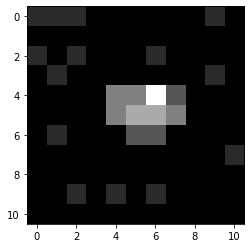

In [37]:
# gets the nth sample bright/dark image with exposure_time_in_ms=2, simply change third index for n

import matplotlib.pyplot as plt

#sample_dark = all_images['dark'][4][11]
sample_bright = all_images['bright'][4][11]
#print(np.round(sample_bright,3))
plt.figure()
plt.imshow(sample_bright, cmap=plt.get_cmap('gray'))# vmin=0.0, vmax=15.0)
#print(sample_dark)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in power
  # Remove the CWD from sys.path while we load stuff.


2054.4282543760773 0.16721405149660362
lambda=0.16721405149660362 for row 5, col 0
2320.0262105696715 0.12881025955471526
lambda=0.12881025955471526 for row 5, col 1
2036.502256981189 0.1737207081335083
lambda=0.1737207081335083 for row 5, col 2
1646.311006898564 0.2818883663983909
lambda=0.2818883663983909 for row 5, col 3
1008.1339294886832 1.6719328941564606
lambda=1.6719328941564606 for row 5, col 4
941.6127161651789 5.366286745636333
lambda=5.366286745636333 for row 5, col 5
951.6652491186653 6.507663005301575
lambda=6.507663005301575 for row 5, col 6
957.5326132350208 2.9385759082085046
lambda=2.9385759082085046 for row 5, col 7
1349.0090752251938 0.4846199984244719
lambda=0.4846199984244719 for row 5, col 8
2047.0175930145676 0.16970275381281055
lambda=0.16970275381281055 for row 5, col 9


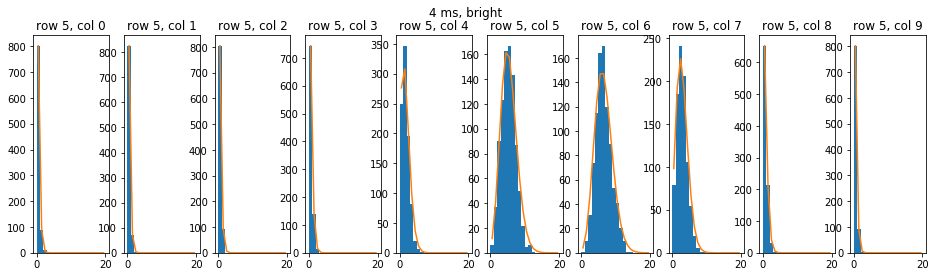

In [38]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson
from scipy.special import gamma
import math

def fit_function_poisson(x, A, lamb):
    b = 1
    bx = np.multiply(b, x)
    return A*np.exp(-lamb)*(lamb**(bx)/gamma(bx+1))

def fit_function_gaussian(x, A, x0, sigma):
    return np.multiply(A, np.exp(-(np.subtract(x, x0))**2 / (2 * sigma**2)))

def fit_function_poisson_gaussian_sum(x, A_poisson, lamb, b): #, A_gaussian, x0, sigma):
    A_gaussian = 122.61271136259133
    x0 = 2492545.215280129
    sigma = 862329.7365410712
    return np.add(fit_function_poisson(x, A_poisson, lamb, b), fit_function_gaussian(x, A_gaussian, x0, sigma))

fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(16,4))
exposure_time_in_ms = 4
row = 5
#for row in range(4,7):
for col in range(0, 10): 
    one_pixel_bright = [image[row][col] - np.amin(sample_bright) for image in all_images['bright'][exposure_time_in_ms]]
    y,x,_ = axes[col].hist(np.array(one_pixel_bright).ravel(),bins=20, range=(0,20)) #range=(136904704,152891904));
    x1 = [(x[i] + x[i+1]) / 2 for i in range(len(x) - 1)]

    initial_guess_poisson = [500,3]
    #initial_guess_gaussian = [100, 0.25e7, 0.1e7]
    try:
        popt, pcov = curve_fit(fit_function_poisson, x1, y, p0=initial_guess_poisson, bounds=(-np.inf, np.inf))
        axes[col].plot(x1, fit_function_poisson(x1, *popt))
        print(*popt)
        print(f'lambda={popt[1]} for row {row}, col {col}')
    except:
        print(f'failed to fit for row {row}, col {col}')

    #axes[col].plot(np.linspace(0,152891904,10000),[fit_function_poisson(x,*initial_guess_poisson) for x in np.linspace(0,152891904,10000)],'k--', label='initial guess', lw=2)
    #axes[col].plot(x1,[fit_function_poisson(x,*initial_guess_poisson) for x in x1],'k--', label='initial guess', lw=2)

    axes[col].set_title(f'row {row}, col {col}')
plt.suptitle(f'{exposure_time_in_ms} ms, bright')
plt.show()



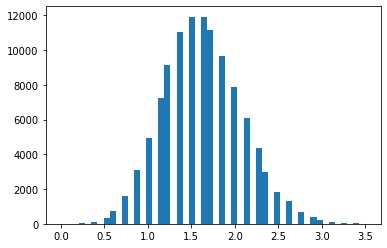

In [79]:
plt.hist(np.array(all_images['dark'][0.2]).ravel(),bins=50, range=(0,3.5));

## plot the mean bright image for every exposure time

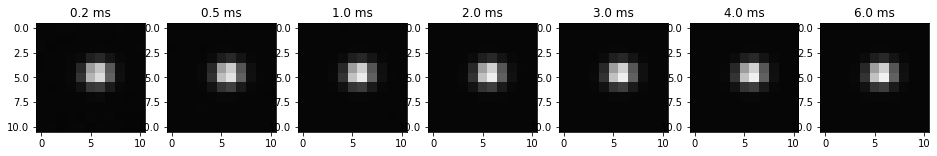

In [93]:
# plot the mean bright image for every exposure time
fig, axes = plt.subplots(nrows=1, ncols=len(all_images['bright']), figsize=(16,4))
for i, exposure_time_in_ms in enumerate(sorted(all_images['bright'])):
    avg_image = np.mean(all_images['bright'][exposure_time_in_ms], 0)
    #print(f'average image for exposure time {exposure_time_in_ms} ms:\n{np.round(avg_image,3)}')
    axes[i].imshow(avg_image, cmap=plt.get_cmap('gray'), vmin=0.0, vmax=1.0)
    axes[i].set_title(f'{exposure_time_in_ms} ms')

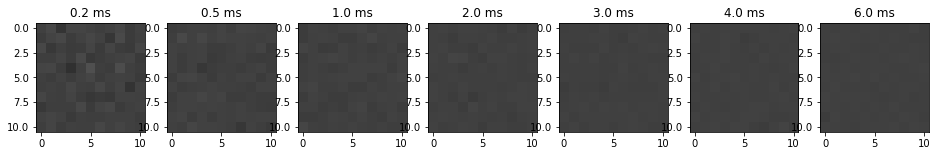

In [96]:
# plot the mean dark image for every exposure time
fig, axes = plt.subplots(nrows=1, ncols=len(all_images['dark']), figsize=(16,4))
for i, exposure_time_in_ms in enumerate(sorted(all_images['dark'])):
    avg_image = np.mean(all_images['dark'][exposure_time_in_ms], 0)
    #print(f'average image for exposure time {exposure_time_in_ms} ms:\n{np.round(avg_image,3)}')
    axes[i].imshow(avg_image, cmap=plt.get_cmap('gray'), vmin=0.0, vmax=0.1)
    axes[i].set_title(f'{exposure_time_in_ms} ms')

## calculating variance

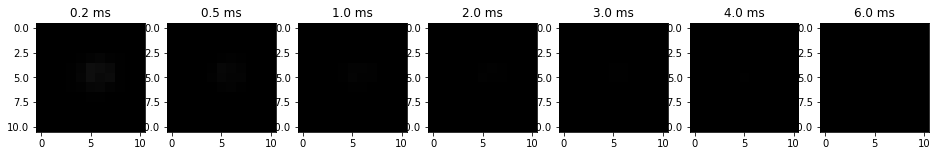

In [95]:
# plot the variance bright image for every exposure time
fig, axes = plt.subplots(nrows=1, ncols=len(all_images['bright']), figsize=(16,4))
for i, exposure_time_in_ms in enumerate(sorted(all_images['bright'])):
    avg_image = np.var(all_images['bright'][exposure_time_in_ms], 0)
    #print(f'average image for exposure time {exposure_time_in_ms} ms:\n{np.round(avg_image,3)}')
    axes[i].imshow(avg_image, cmap=plt.get_cmap('gray'), vmin=0.0, vmax=1.0)
    axes[i].set_title(f'{exposure_time_in_ms} ms')

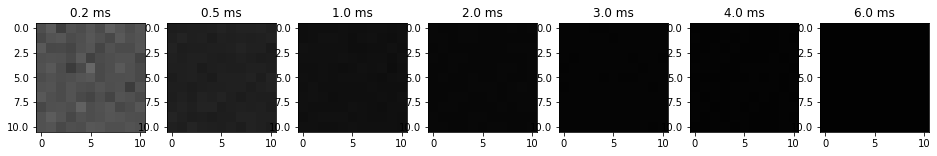

In [98]:
# plot the variance dark image for every exposure time
fig, axes = plt.subplots(nrows=1, ncols=len(all_images['dark']), figsize=(16,4))
for i, exposure_time_in_ms in enumerate(sorted(all_images['dark'])):
    avg_image = np.var(all_images['dark'][exposure_time_in_ms], 0)
    #print(f'average image for exposure time {exposure_time_in_ms} ms:\n{np.round(avg_image,3)}')
    axes[i].imshow(avg_image, cmap=plt.get_cmap('gray'), vmin=0.0, vmax=0.01)
    axes[i].set_title(f'{exposure_time_in_ms} ms')

In [ ]:
exposure_time_in_ms = 2
avg_image = np.var(all_images['bright'][exposure_time_in_ms], 0)
print(avg_image);

163


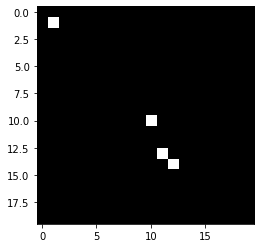

In [19]:
bright = 0
for i in range(1000):
    image_data = plot_image(0.01, True)
    #result = detect_ion_state(image_data)
    if image_data[10][10][1] > 0.7:
        bright += 1
print(bright)

In [15]:
# plot the mean bright image for every exposure time
fig, axes = plt.subplots(nrows=1, ncols=len(all_images['bright']), figsize=(16,4))
for i, exposure_time_in_ms in (0.01,10):
    avg_image = np.mean(all_images['bright'][exposure_time_in_ms], 0)
    #print(f'average image for exposure time {exposure_time_in_ms} ms:\n{np.round(avg_image,3)}')
    axes[i].imshow(avg_image, cmap=plt.get_cmap('gray'), vmin=0.0, vmax=1.0)
    axes[i].set_title(f'{exposure_time_in_ms} ms')

1.0

array([[[0.05      , 0.05      , 0.05      ],
        [0.06666667, 0.06666667, 0.06666667],
        [0.13333333, 0.13333333, 0.13333333],
        ...,
        [0.05      , 0.05      , 0.05      ],
        [0.06666667, 0.06666667, 0.06666667],
        [0.03333333, 0.03333333, 0.03333333]],

       [[0.06666667, 0.06666667, 0.06666667],
        [0.08333333, 0.08333333, 0.08333333],
        [0.03333333, 0.03333333, 0.03333333],
        ...,
        [0.06666667, 0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667],
        [0.06666667, 0.06666667, 0.06666667]],

       [[0.11666667, 0.11666667, 0.11666667],
        [0.05      , 0.05      , 0.05      ],
        [0.1       , 0.1       , 0.1       ],
        ...,
        [0.01666667, 0.01666667, 0.01666667],
        [0.06666667, 0.06666667, 0.06666667],
        [0.03333333, 0.03333333, 0.03333333]],

       ...,

       [[0.03333333, 0.03333333, 0.03333333],
        [0.08333333, 0.08333333, 0.08333333],
        [0.05      , 0

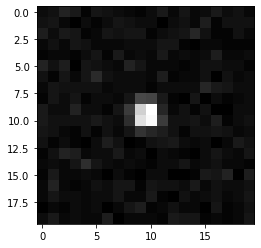

In [16]:
plot_image(3,True)

In [ ]:
bright = 0
for i in range(100):
    image_data = plot_image(2, True)
    #result = detect_ion_state(image_data)
    if image_data[10][10][0] > 0.3:
        bright += 1
print(bright)

In [5]:
min(255,int(round(value * 255))) for value in data_float[i][j]

SyntaxError: invalid syntax (<ipython-input-5-aa4f65e3ae71>, line 1)

In [151]:
np.random.poisson(0,255)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

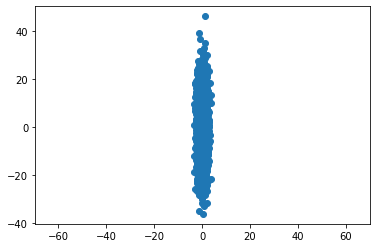

In [26]:
import matplotlib.pyplot as plt
mean = [0, 0]
cov = [[1, 0], [0, 100]]  # diagonal covariance
x, y = np.random.multivariate_normal(mean, cov, 5000).T
plt.plot(x, y, 'o')
plt.axis('equal')
plt.show()

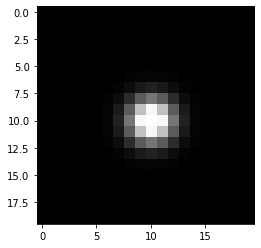

In [39]:
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
from scipy.stats import multivariate_normal



img_w, img_h = 20, 20
data = np.zeros((img_h, img_w, 3), dtype=np.uint8)

mu = [img_w/2,img_h/2]
Sigma = np.array([[ 2 , 0], [0,  2]])
F = multivariate_normal(mu, Sigma)
#Z = F.pdf(pos)

def gaussian(x, y):
    return F.pdf([x,y])
for x in range(5, 15):
    for y in range(5, 15):
        amplitude = np.uint8(min(255, 4000*gaussian(x,y)))
        data[x, y] = [amplitude, amplitude, amplitude]
        

# for x in range(0,3):
#     for y in range(0,5):
#         data[x,y] = [20,20,20]
        
# for x in range(3,5):
#     for y in range(3,5):
#         data[x,y] = [40,40,40]
        
# for x in range(17,20):
#     for y in range(17,20):
#         data[x,y] = [20,20,20]

# for x in range(15,17):
#     for y in range(15,17):
#         data[x,y] = [40,40,40]
# for x in range(15,17):
#     for y in range(0,3):
#         data[x,y] = [40,40,40]
# for x in range(17,20):
#     for y in range(0,3):
#         data[x,y] = [20,20,20]
#img = Image.fromarray(data, 'RGB')
imshow(data)
#img.save('/Users/suman/OneDrive/Documents/QuantumOptics_Julia/Camera_project/test.png')
#img.axis()
